In [457]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical

In [458]:
# Assuming 'monks1_train_path' is the path to your data file
monks1_train_path = os.getcwd() + '/../../data/monks/monks-1.train'

# Specify the column names or let pandas infer them
column_names = ['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id']

# Load the data into a pandas DataFrame
df = pd.read_csv(monks1_train_path, names=column_names, delimiter=' ')

# Display the loaded data
df

,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,3,1,data_5
NaN,1,1,1,1,1,3,2,data_6
NaN,1,1,1,1,3,2,1,data_19
NaN,1,1,1,1,3,3,2,data_22
NaN,1,1,1,2,1,2,1,data_27
...,...,...,...,...,...,...,...,...
NaN,1,3,3,2,1,4,2,data_416
NaN,1,3,3,2,3,1,2,data_426
NaN,1,3,3,2,3,2,2,data_428
NaN,1,3,3,2,3,3,2,data_430


In [462]:
# Saving target and IDs before drop
y  = df['target'].values.astype(float)
id = df['id'].values.astype(str)

# Creating TR+VL set (X)
#df = df.drop('target', axis=1)
#df = df.drop('id', axis=1)
#X_one_hot = df.values.astype(float)
#X_one_hot.shape

# 1-hot encoding on columns (except target and id)
df = df.drop('target', axis=1)
df = df.drop('id', axis=1)
#X_one_hot = pd.get_dummies(df, prefix='', prefix_sep='').values.astype(float)
X_one_hot = to_categorical(df.values.astype(float))
X_one_hot.shape[1]


# Substract 1 to match indexing
#X_one_hot.shape

KeyError: 'target'

### Model Selection

In [460]:
# Define the search space
#param_space = {
#    'units': [3, 4],
#    'optimizer': ['adam', 'sgd'],
#   'learning_rate': [0.06, 0.05, 0.07, 0.08, 0.1],
#    'batch_size': [16, 32, 64],
#    'epochs': [50, 60, 70, 80],
#    'weight_decay': [0.001, 0.01, 0.002, 0.003],
#    'momentum': [0.7, 0.8, 0.9]
#}
param_space = {
    'units': [3, 4],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.06, 0.05, 0.07, 0.08, 0.1],
    'batch_size': [16, 20, 31, 32, 33, 50, 54, 63, 64],
    'epochs': [100, 200, 500, 700, 1000],
    'weight_decay': [0.001, 0.01, 0.002, 0.003],
    'momentum': [0.7, 0.8, 0.9]
}

# Number of random combinations to try
num_trials = 15

for _ in range(num_trials):
    
    # Randomly sample from the search space
    params = {
        'units': np.random.choice(param_space['units']),
        'optimizer': np.random.choice(param_space['optimizer']),
        'learning_rate': np.random.choice(param_space['learning_rate']),
        'batch_size': np.random.choice(param_space['batch_size']),
        'epochs': np.random.choice(param_space['epochs']),
        'weight_decay': np.random.choice(param_space['weight_decay']),
        'momentum': np.random.choice(param_space['momentum'])
        
    }

    # Build the Keras model
    model = Sequential()
    model.add(Dense(units=params['units'], input_shape=X_one_hot.shape[1:], activation='relu', kernel_regularizer=regularizers.l2(params['weight_decay'])))
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Set the optimizer with the sampled learning rate
    if params['optimizer'] == 'adam':
        optimizer = optimizers.Adam()
    elif params['optimizer'] == 'sgd':
        optimizer = optimizers.SGD()
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_one_hot,
        y,
        epochs=params['epochs'],
        batch_size=params['batch_size'], 
        validation_split=0.2, 
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_one_hot, y, verbose=0)

    # Print of the higest accuracies
    if accuracy > 0.6:

        # Plot the learning curve
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Learning Curve')
        plt.xlabel('Epoch')
        plt.legend()

        # Print the used parameters
        print(f"Trial {_:>2}: Units={params['units']}, Decay={params['weight_decay']}, Batch Size={params['batch_size']}, Accuracy={accuracy:.4f}")



ValueError: in user code:

    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 6, 1) vs (None,)).


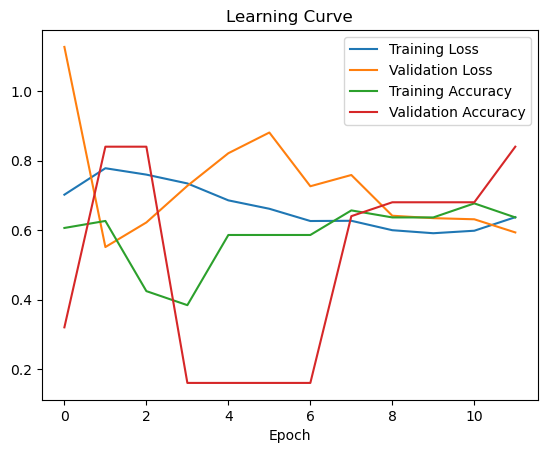